In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.dataLoader import loadSession
from src.features import *

Preprocessing

In [2]:
# loading all the sessions in Hungarian GP

fp1 = loadSession(2024, 'Hungary', 'FP1')
fp2 = loadSession(2024, 'Hungary', 'FP2')
fp3 = loadSession(2024, 'Hungary', 'FP3')
quali = loadSession(2024, 'Hungary', 'Q')
race = loadSession(2024, 'Hungary', 'R')

core           INFO 	Loading data for Hungarian Grand Prix - Practice 1 [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '50', '55', '63', '77', '81']
core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v3.6.0]
req            INFO 	Using

In [3]:
df = getBestLaps(fp1)
df = df.merge(getAvg_top3Laps(fp2), on="Driver", how="outer")
df = df.merge(getAvg_top3Laps(fp3), on="Driver", how="outer")
df = df.merge(getQualiResults(quali), on="Driver", how="outer")
df = df.merge(getRacePositions(race), on="Driver", how="outer")


In [4]:
df.sort_values('Race_result', inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df.head(10)

,Driver,Practice 1_BestLap,Practice 2_Top3Average,Practice 3_Top3Average,Quali_Position,Race_result
0,PIA,0 days 00:01:19.249000,0 days 00:01:19.438333333,0 days 00:01:16.902000,2.0,1
1,STR,0 days 00:01:19.265000,0 days 00:01:19.606666666,0 days 00:01:17.939000,8.0,10
2,ALO,0 days 00:01:19.686000,0 days 00:01:19.247000,0 days 00:01:17.614333333,7.0,11
3,RIC,0 days 00:01:19.578000,0 days 00:01:18.689500,0 days 00:01:17.334000,9.0,12
4,HUL,NaT,0 days 00:01:19.366666666,0 days 00:01:17.283000,11.0,13
5,ALB,0 days 00:01:19.794000,0 days 00:01:19.065666666,0 days 00:01:17.279000,13.0,14
6,MAG,0 days 00:01:20.295000,0 days 00:01:19.502000,0 days 00:01:17.854666666,15.0,15
7,BOT,0 days 00:01:19.804000,0 days 00:01:18.946000,0 days 00:01:17.577666666,12.0,16
8,SAR,0 days 00:01:19.885000,0 days 00:01:19.074000,0 days 00:01:17.637333333,14.0,17
9,OCO,0 days 00:01:20.023000,0 days 00:01:19.194666666,0 days 00:01:17.973000,19.0,18


In [6]:
from src.preProcessing import processFeatures

df_clean = processFeatures(df)
df_clean.head()

,Driver,Practice 1_BestLap,Practice 2_Top3Average,Practice 3_Top3Average,Quali_Position,Race_result
0,PIA,0 days 00:01:19.249000,79.438333,76.902000,2.0,1
1,STR,0 days 00:01:19.265000,79.606667,77.939000,8.0,10
2,ALO,0 days 00:01:19.686000,79.247000,77.614333,7.0,11
3,RIC,0 days 00:01:19.578000,78.689500,77.334000,9.0,12
4,HUL,NaT,79.366667,77.283000,11.0,13


In [7]:
for column in df_clean.columns:
  print (column)

Driver
Practice 1_BestLap
Practice 2_Top3Average
Practice 3_Top3Average
Quali_Position
Race_result


In [8]:
df["Practice 1_BestLap"] = pd.to_timedelta(df["Practice 1_BestLap"], errors="coerce")
df["Practice 1_BestLap"] = df["Practice 1_BestLap"].dt.total_seconds()

df_clean = df[df["Race_result"].apply(lambda x: str(x).isdigit())].copy()
df_clean["Race_result"] = df_clean["Race_result"].astype(int)

In [9]:
df.head(10)

,Driver,Practice 1_BestLap,Practice 2_Top3Average,Practice 3_Top3Average,Quali_Position,Race_result
0,PIA,79.249,79.438333,76.902000,2.0,1
1,STR,79.265,79.606667,77.939000,8.0,10
2,ALO,79.686,79.247000,77.614333,7.0,11
3,RIC,79.578,78.689500,77.334000,9.0,12
4,HUL,NaN,79.366667,77.283000,11.0,13
5,ALB,79.794,79.065667,77.279000,13.0,14
6,MAG,80.295,79.502000,77.854667,15.0,15
7,BOT,79.804,78.946000,77.577667,12.0,16
8,SAR,79.885,79.074000,77.637333,14.0,17
9,OCO,80.023,79.194667,77.973000,19.0,18


Preparing the features and target

In [10]:
from sklearn.model_selection import train_test_split

df_clean1 = df_clean.copy()
X = df_clean1.drop(columns=["Driver", "Race_result"])
y = df_clean1["Race_result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Using Xg boost for training the model

In [11]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")


MAE: 1.54


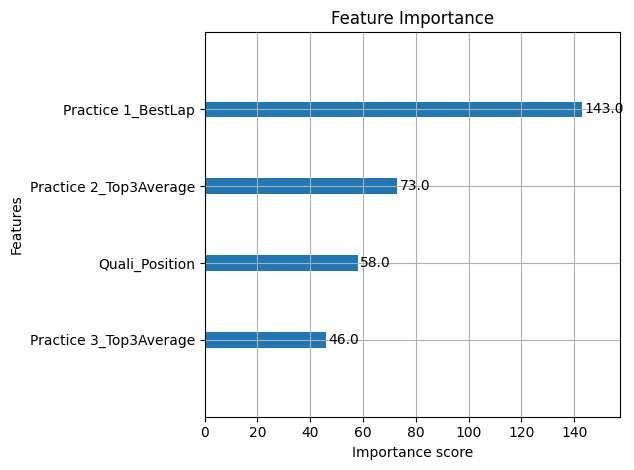

In [12]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

Using the extacted features

In [13]:
df_dynamics = pd.read_csv("../data/processed/hungary_2024_full_features.csv")

In [14]:
df_dynamics.head()

,Driver,Practice 1_BestLap,Practice 2_Top3Average,Practice 3_Top3Average,Quali_Position,Race_result,maxSpeed,avgCornerSpeed,avgThrottle,avgBrake,ConstructorPoints,ConstructorWins,ConstructorNationality,HARD,MEDIUM,SOFT,DriverPoints,DriverWins,Constructor
0,PIA,79.249,79.438333,76.902000,2.0,1,308.0,129.553846,67.693662,0.172535,374.0,4,British,29,41,0,292.0,2,McLaren
1,STR,79.265,79.606667,77.939000,8.0,10,319.0,130.338028,66.522968,0.204947,70.0,0,British,25,31,14,24.0,0,Aston Martin
2,ALO,79.686,79.247000,77.614333,7.0,11,316.0,129.486111,67.730496,0.177305,70.0,0,British,33,30,7,70.0,0,Aston Martin
3,RIC,79.578,78.689500,77.334000,9.0,12,312.0,130.957746,69.679577,0.179577,30.0,0,Italian,62,7,0,12.0,0,RB F1 Team
4,HUL,NaN,79.366667,77.283000,11.0,13,324.0,129.162500,68.776632,0.192440,41.0,0,American,67,2,0,41.0,0,Haas F1 Team


In [15]:
for col in df_dynamics.columns:
    print(col)

Driver
Practice 1_BestLap
Practice 2_Top3Average
Practice 3_Top3Average
Quali_Position
Race_result
maxSpeed
avgCornerSpeed
avgThrottle
avgBrake
ConstructorPoints
ConstructorWins
ConstructorNationality
HARD
MEDIUM
SOFT
DriverPoints
DriverWins
Constructor


In [16]:
for col in df_clean.columns:
    print(col)

Driver
Practice 1_BestLap
Practice 2_Top3Average
Practice 3_Top3Average
Quali_Position
Race_result


In [17]:
overlap_cols = ['Practice 1_BestLap', 'Practice 2_Top3Average', 'Practice 3_Top3Average', 'Quali_Position', 'Race_result']
df_dynamics_unique = df_dynamics.drop(columns=overlap_cols)

df_combined = df_clean.merge(df_dynamics_unique, on='Driver', how='left')
for col in df_combined.columns:
    print(col)

Driver
Practice 1_BestLap
Practice 2_Top3Average
Practice 3_Top3Average
Quali_Position
Race_result
maxSpeed
avgCornerSpeed
avgThrottle
avgBrake
ConstructorPoints
ConstructorWins
ConstructorNationality
HARD
MEDIUM
SOFT
DriverPoints
DriverWins
Constructor


Getting more data for context

In [18]:
from fastf1.ergast import Ergast

ergast = Ergast()
season_data = ergast.get_driver_standings(season=2024).content[0]
print ("Season data: \n")
for col in season_data.columns:
    print(col)

Season data: 

position
positionText
points
wins
driverId
driverNumber
driverCode
driverUrl
givenName
familyName
dateOfBirth
driverNationality
constructorIds
constructorUrls
constructorNames
constructorNationalities


In [19]:
print ("Team Data : \n")
team_data = ergast.get_constructor_standings(season=2024).content[0]
for col in team_data.columns:
    print(col)

Team Data : 

position
positionText
points
wins
constructorId
constructorUrl
constructorName
constructorNationality


In [20]:
driver_standings = ergast.get_driver_standings(season=2024)
season_data = driver_standings.content[0]  
df_driver_context = season_data.rename(columns={
    'driverCode': 'Driver',
    'points': 'DriverPoints',
    'wins': 'DriverWins',
    'constructorNames': 'Constructor'
})[['Driver', 'DriverPoints', 'DriverWins', 'Constructor']]

df_driver_context['Constructor'] = df_driver_context['Constructor'].apply(lambda x: x[0])
df_driver_context.head()

,Driver,DriverPoints,DriverWins,Constructor
0,VER,437.0,9,Red Bull
1,NOR,374.0,4,McLaren
2,LEC,356.0,3,Ferrari
3,PIA,292.0,2,McLaren
4,SAI,290.0,2,Ferrari


In [21]:
for col in df_combined.columns:
    for col2 in df_driver_context.columns:
        if col == col2:
            print(f"Column {col} exists in both dataframes.")

Column Driver exists in both dataframes.
Column DriverPoints exists in both dataframes.
Column DriverWins exists in both dataframes.
Column Constructor exists in both dataframes.


In [22]:
overlap_cols = ['DriverPoints', 'DriverWins', 'Constructor']
df_combined = df_combined.drop(columns=overlap_cols)

In [23]:
for col in df_combined.columns:
  print(col)

Driver
Practice 1_BestLap
Practice 2_Top3Average
Practice 3_Top3Average
Quali_Position
Race_result
maxSpeed
avgCornerSpeed
avgThrottle
avgBrake
ConstructorPoints
ConstructorWins
ConstructorNationality
HARD
MEDIUM
SOFT


In [24]:
df_final = df_combined.merge(df_driver_context, on='Driver', how='left')
df_final.head()


,Driver,Practice 1_BestLap,Practice 2_Top3Average,Practice 3_Top3Average,Quali_Position,Race_result,maxSpeed,avgCornerSpeed,avgThrottle,avgBrake,ConstructorPoints,ConstructorWins,ConstructorNationality,HARD,MEDIUM,SOFT,DriverPoints,DriverWins,Constructor
0,PIA,79.249,79.438333,76.902000,2.0,1,308.0,129.553846,67.693662,0.172535,374.0,4,British,29,41,0,292.0,2,McLaren
1,STR,79.265,79.606667,77.939000,8.0,10,319.0,130.338028,66.522968,0.204947,70.0,0,British,25,31,14,24.0,0,Aston Martin
2,ALO,79.686,79.247000,77.614333,7.0,11,316.0,129.486111,67.730496,0.177305,70.0,0,British,33,30,7,70.0,0,Aston Martin
3,RIC,79.578,78.689500,77.334000,9.0,12,312.0,130.957746,69.679577,0.179577,30.0,0,Italian,62,7,0,12.0,0,RB F1 Team
4,HUL,NaN,79.366667,77.283000,11.0,13,324.0,129.162500,68.776632,0.192440,41.0,0,American,67,2,0,41.0,0,Haas F1 Team


In [25]:
for col in df_final.columns:
    print(col)

Driver
Practice 1_BestLap
Practice 2_Top3Average
Practice 3_Top3Average
Quali_Position
Race_result
maxSpeed
avgCornerSpeed
avgThrottle
avgBrake
ConstructorPoints
ConstructorWins
ConstructorNationality
HARD
MEDIUM
SOFT
DriverPoints
DriverWins
Constructor


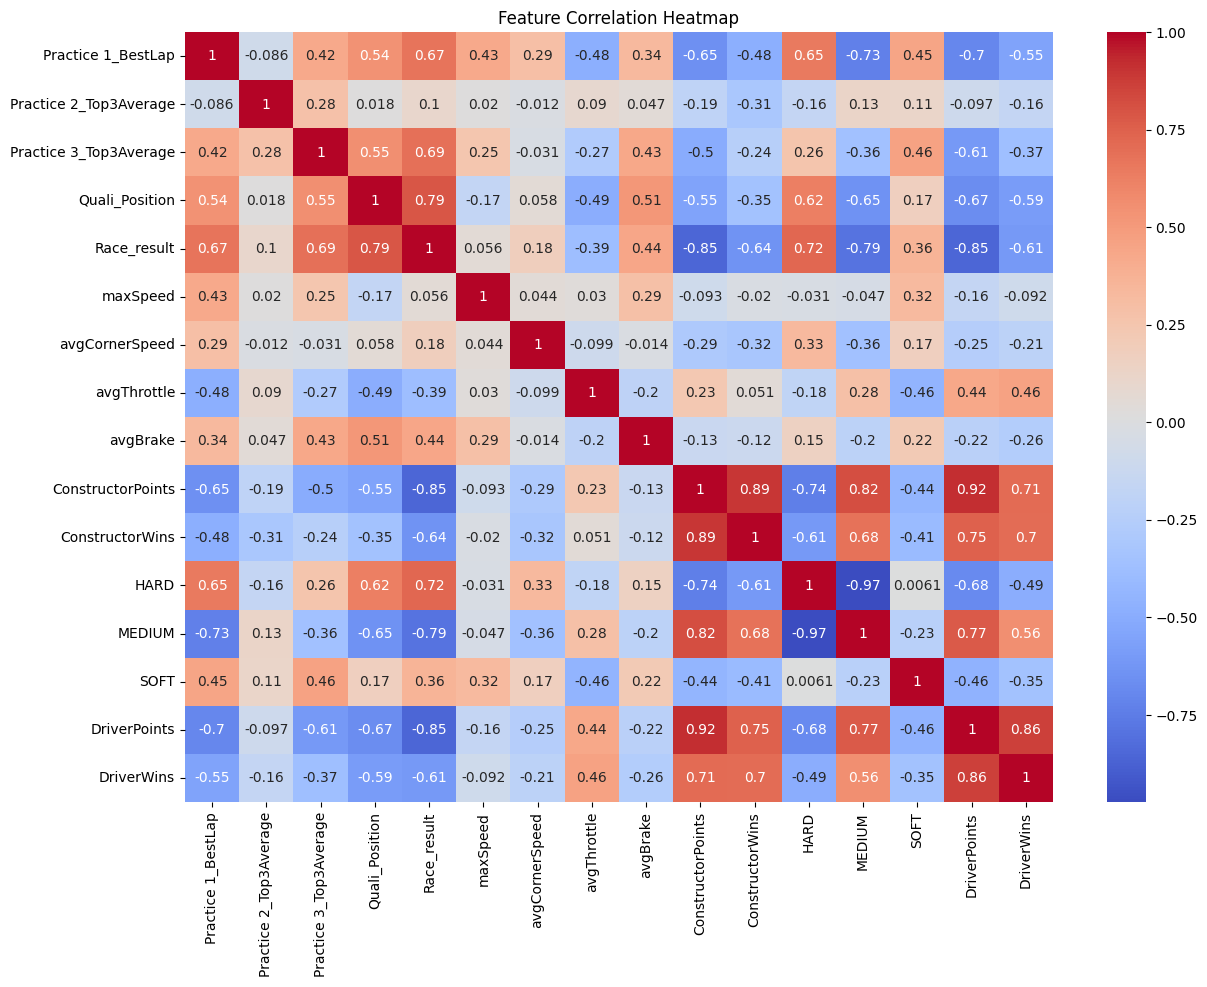

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(df_final.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [27]:
df_corr = df_final.select_dtypes(include='number') 
correlations = df_corr.corr()['Race_result'].sort_values(ascending=False)
print("Correlation of each feature with Race_result:\n")
print(correlations)

Correlation of each feature with Race_result:

Race_result               1.000000
Quali_Position            0.787719
HARD                      0.722605
Practice 3_Top3Average    0.685486
Practice 1_BestLap        0.673848
avgBrake                  0.442372
SOFT                      0.360463
avgCornerSpeed            0.177769
Practice 2_Top3Average    0.099713
maxSpeed                  0.055776
avgThrottle              -0.387031
DriverWins               -0.608037
ConstructorWins          -0.639145
MEDIUM                   -0.790313
ConstructorPoints        -0.851673
DriverPoints             -0.852163
Name: Race_result, dtype: float64


In [28]:
df_final.to_csv("../data/processed/hungary_2024_full_features.csv", index=False)

In [29]:
df_final1 = df_final.copy()

MAE: 3.34


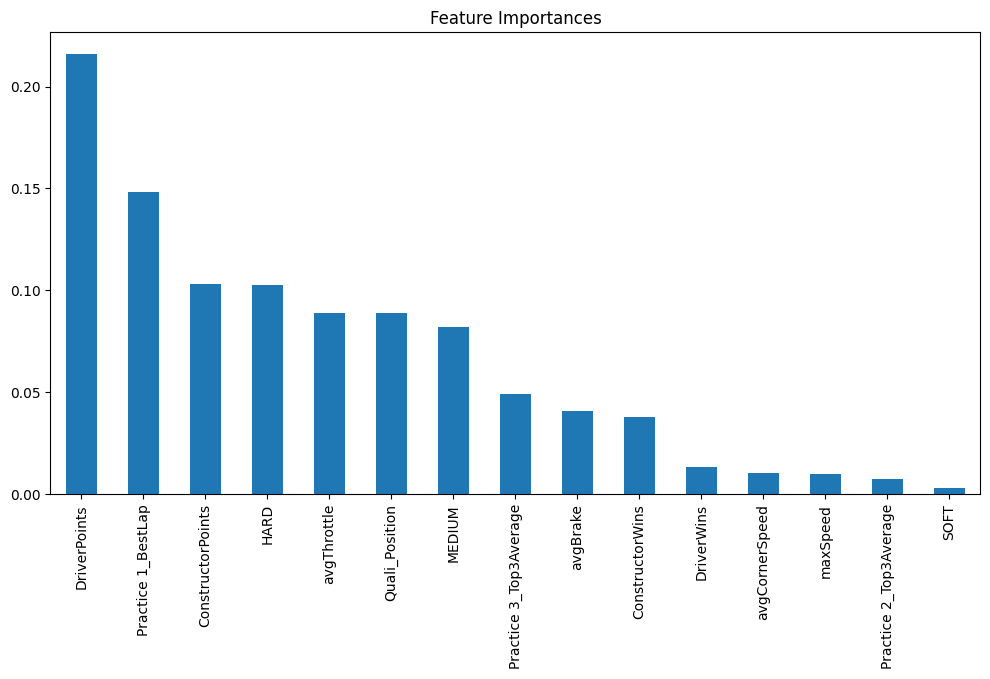

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

features = df_final.drop(columns=[
    'Driver', 'Constructor', 'ConstructorNationality', 'Race_result'
])
target = df_final['Race_result']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"MAE: {mae:.2f}")

importances = pd.Series(model.feature_importances_, index=features.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,6), title="Feature Importances")
plt.show()


Dropping the Following columns due to negative corealtion

avgThrottle                            
ConstructorWins        
DriverPoints   
ConstructorPoints  
          

In [32]:
low_corr_features = ['avgThrottle', 'ConstructorWins', 'ConstructorPoints', 'DriverWins']
df = df_final.copy()
df_filtered = df.drop(columns=low_corr_features)

In [33]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

params = {
    "n_estimators": [100, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0]
}
model = XGBRegressor(random_state=42)
grid = GridSearchCV(model, param_grid=params, scoring='neg_mean_absolute_error', cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best MAE:", -grid.best_score_)

Best MAE: 3.023517537117004


In [36]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 0.5, 1],
    "reg_lambda": [0.5, 1, 1.5]
}
model = XGBRegressor(random_state=42)
rand_search = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

rand_search.fit(X_train, y_train)
best_model = rand_search.best_estimator_
print("Best MAE:", -rand_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best MAE: 2.456065368652344


Lets add average car pace data (before Hungarian GP obv),

currently not talking an account on car upgardes

In [2]:
import fastf1
from fastf1 import get_event_schedule
import pandas as pd
from datetime import datetime

fastf1.Cache.enable_cache('../data/raw')
schedule = get_event_schedule(2024)
schedule = schedule[schedule['EventFormat'] != 'Testing']  
hungary_round = schedule[schedule['Country'] == 'Hungary'].index[0]

past_rounds = schedule[schedule.index < hungary_round]
print(f"Rounds before Hungarian GP ({hungary_round}):")
display(past_rounds[['RoundNumber', 'EventName', 'Country', 'Location']])


Rounds before Hungarian GP (13):


,RoundNumber,EventName,Country,Location
0,0,Pre-Season Testing,Bahrain,Sakhir
1,1,Bahrain Grand Prix,Bahrain,Sakhir
2,2,Saudi Arabian Grand Prix,Saudi Arabia,Jeddah
3,3,Australian Grand Prix,Australia,Melbourne
4,4,Japanese Grand Prix,Japan,Suzuka
5,5,Chinese Grand Prix,China,Shanghai
6,6,Miami Grand Prix,United States,Miami
7,7,Emilia Romagna Grand Prix,Italy,Imola
8,8,Monaco Grand Prix,Monaco,Monaco
9,9,Canadian Grand Prix,Canada,Montréal


In [1]:
from collections import defaultdict
fastf1.Cache.enable_cache('../data/raw')

schedule = get_event_schedule(2024)
schedule = schedule[schedule['EventFormat'] != 'Testing']

hungary_round = schedule[schedule['Country'] == 'Hungary'].index[0]
past_rounds = schedule[schedule.index < hungary_round]
qualifying_positions = defaultdict(list)
race_deltas = defaultdict(list)

for rnd in past_rounds.index:
    try:
        event = fastf1.get_event(2024, rnd)
        print(f"Processing {event['EventName']} ({rnd})...")
        session_quali = event.get_session('Q') 
        session_quali.load()
        for drv in session_quali.results.itertuples():
            driver_code = drv.Abbreviation
            if drv.Position > 0:
                qualifying_positions[driver_code].append(drv.Position)

        # RACE
        session_race = event.get_session('R')
        session_race.load()
        
        laps = session_race.laps.pick_quicklaps()
        if laps.empty:
            continue
        
        fastest_lap = laps.pick_fastest()
        fastest_time = fastest_lap['LapTime'].total_seconds()

        for drv in laps['Driver'].unique():
            drv_laps = laps.pick_driver(drv)
            if drv_laps.empty:
                continue
            best_lap = drv_laps.pick_fastest()
            delta = best_lap['LapTime'].total_seconds() - fastest_time
            race_deltas[drv].append(delta)

    except Exception as e:
        print(f"Skipping round {rnd} due to error: {e}")
        continue


NameError: name 'fastf1' is not defined

In [39]:
qualifying_df = pd.DataFrame([
    {'Driver': drv, 'AvgQualiPosition': sum(pos)/len(pos)}
    for drv, pos in qualifying_positions.items()
])

race_delta_df = pd.DataFrame([
    {'Driver': drv, 'AvgRacePaceDelta': sum(deltas)/len(deltas)}
    for drv, deltas in race_deltas.items()
])

df_contextual = pd.merge(qualifying_df, race_delta_df, on='Driver', how='outer')
df_contextual.sort_values('AvgQualiPosition', inplace=True)
print("\n Final contextual DataFrame:")
display(df_contextual)


 Final contextual DataFrame:


,Driver,AvgQualiPosition,AvgRacePaceDelta
19,VER,1.833333,0.742083
9,NOR,3.750000,0.835333
14,RUS,5.083333,1.215750
15,SAI,5.181818,1.255000
7,LEC,5.250000,1.028545
12,PIA,5.500000,1.125500
5,HAM,7.750000,1.181500
11,PER,8.083333,1.286727
1,ALO,9.833333,1.117583
2,BEA,11.000000,0.554000


In [40]:
df_final = pd.merge(df_final, df_contextual, on='Driver', how='left')

print(df_final.columns)
df_final.head()

Index(['Driver', 'Practice 1_BestLap', 'Practice 2_Top3Average',
       'Practice 3_Top3Average', 'Quali_Position', 'Race_result', 'maxSpeed',
       'avgCornerSpeed', 'avgThrottle', 'avgBrake', 'ConstructorPoints',
       'ConstructorWins', 'ConstructorNationality', 'HARD', 'MEDIUM', 'SOFT',
       'DriverPoints', 'DriverWins', 'Constructor', 'AvgQualiPosition',
       'AvgRacePaceDelta'],
      dtype='object')


,Driver,Practice 1_BestLap,Practice 2_Top3Average,Practice 3_Top3Average,Quali_Position,Race_result,maxSpeed,avgCornerSpeed,avgThrottle,avgBrake,...,ConstructorWins,ConstructorNationality,HARD,MEDIUM,SOFT,DriverPoints,DriverWins,Constructor,AvgQualiPosition,AvgRacePaceDelta
0,PIA,79.249,79.438333,76.902000,2.0,1,308.0,129.553846,67.693662,0.172535,...,4,British,29,41,0,292.0,2,McLaren,5.500000,1.125500
1,STR,79.265,79.606667,77.939000,8.0,10,319.0,130.338028,66.522968,0.204947,...,0,British,25,31,14,24.0,0,Aston Martin,11.916667,2.119750
2,ALO,79.686,79.247000,77.614333,7.0,11,316.0,129.486111,67.730496,0.177305,...,0,British,33,30,7,70.0,0,Aston Martin,9.833333,1.117583
3,RIC,79.578,78.689500,77.334000,9.0,12,312.0,130.957746,69.679577,0.179577,...,0,Italian,62,7,0,12.0,0,RB F1 Team,13.083333,2.369091
4,HUL,NaN,79.366667,77.283000,11.0,13,324.0,129.162500,68.776632,0.192440,...,0,American,67,2,0,41.0,0,Haas F1 Team,11.833333,1.883545


In [41]:
correlations = df_final.corr(numeric_only=True)['Race_result'].sort_values(ascending=False)
print("New Correlations with Race_result:\n", correlations)

New Correlations with Race_result:
 Race_result               1.000000
AvgQualiPosition          0.911479
AvgRacePaceDelta          0.815295
Quali_Position            0.787719
HARD                      0.722605
Practice 3_Top3Average    0.685486
Practice 1_BestLap        0.673848
avgBrake                  0.442372
SOFT                      0.360463
avgCornerSpeed            0.177769
Practice 2_Top3Average    0.099713
maxSpeed                  0.055776
avgThrottle              -0.387031
DriverWins               -0.608037
ConstructorWins          -0.639145
MEDIUM                   -0.790313
ConstructorPoints        -0.851673
DriverPoints             -0.852163
Name: Race_result, dtype: float64


Retraining the model

In [165]:
selected_features = [
   'AvgQualiPosition',
   'AvgRacePaceDelta', 
   'Quali_Position', 
   'Practice 3_Top3Average',
   'Practice 2_Top3Average',
   'Practice 1_BestLap',
   'HARD',#tire compound for strategy
   'maxSpeed'
]

In [166]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

df_final_copy = df_final.copy()
X = df_final[selected_features]
y = df_final['Race_result']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")


MAE: 2.4520


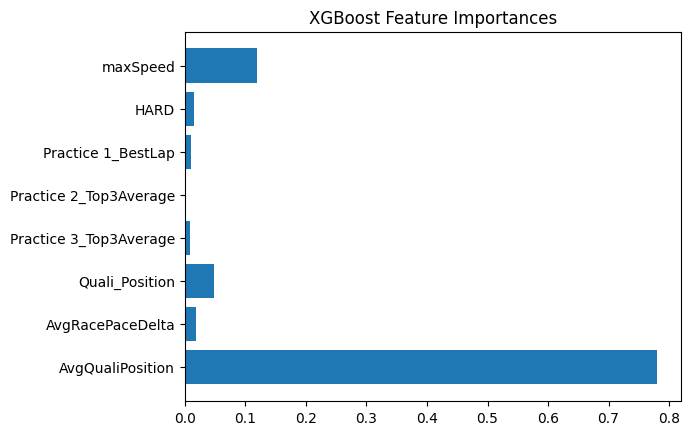

In [44]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
plt.barh(X.columns, importances)
plt.title("XGBoost Feature Importances")
plt.show()


Adding race pace in different sectors, and using some more car data

In [45]:
!pip install tqdm

In [128]:
from fastf1 import get_session, Cache
from tqdm import tqdm
import pandas as pd
import numpy as np

Cache.enable_cache('../data/raw')

year = 2024
gp = 'Hungary'
session_types = ['FP1', 'FP2', 'FP3', 'Q', 'R']

driver_data = {}

for session_type in session_types:
    print(f"\n⏳ Processing {session_type} session...")

    session = get_session(year, gp, session_type)
    session.load(telemetry=True)

    for drv in tqdm(session.drivers):
        try:
            driver_abbr = session.get_driver(drv)['Abbreviation']
            drv_laps = session.laps.pick_driver(drv)
            if drv_laps.empty:
                continue

            fastest_lap = drv_laps.pick_fastest()
            telemetry = fastest_lap.get_telemetry()

            # Mean sector times
            sector1 = drv_laps['Sector1Time'].mean().total_seconds()
            sector2 = drv_laps['Sector2Time'].mean().total_seconds()
            sector3 = drv_laps['Sector3Time'].mean().total_seconds()

            # Speed performance
            high_speed_perf = telemetry[telemetry['Speed'] > 200]['Speed'].mean()
            low_speed_perf = telemetry[telemetry['Speed'] < 100]['Speed'].mean()

            # Brake usage
            avg_brake_pressure = telemetry[telemetry['Brake'] > 0]['Brake'].mean()

            # Throttle aggressiveness
            telemetry['ThrottleDiff'] = telemetry['Throttle'].diff().abs()
            throttle_aggressiveness = telemetry['ThrottleDiff'].mean()

            if driver_abbr not in driver_data:
                driver_data[driver_abbr] = {
                    'Sector1Time_mean': [],
                    'Sector2Time_mean': [],
                    'Sector3Time_mean': [],
                    'HighSpeedCornerPerf': [],
                    'LowSpeedCornerPerf': [],
                    'AvgBrakePressure': [],
                    'ThrottleAggressiveness': []
                }

            # Append values for averaging later
            driver_data[driver_abbr]['Sector1Time_mean'].append(sector1)
            driver_data[driver_abbr]['Sector2Time_mean'].append(sector2)
            driver_data[driver_abbr]['Sector3Time_mean'].append(sector3)
            driver_data[driver_abbr]['HighSpeedCornerPerf'].append(high_speed_perf)
            driver_data[driver_abbr]['LowSpeedCornerPerf'].append(low_speed_perf)
            driver_data[driver_abbr]['AvgBrakePressure'].append(avg_brake_pressure)
            driver_data[driver_abbr]['ThrottleAggressiveness'].append(throttle_aggressiveness)

        except Exception as e:
            print(f"⚠️ Error processing {drv} in {session_type}: {e}")
            continue

# Aggregate all sessions into mean per driver
final_features = []
for driver, feats in driver_data.items():
    final_features.append({
        'Driver': driver,
        'Sector1Time_mean': np.nanmean(feats['Sector1Time_mean']),
        'Sector2Time_mean': np.nanmean(feats['Sector2Time_mean']),
        'Sector3Time_mean': np.nanmean(feats['Sector3Time_mean']),
        'HighSpeedCornerPerf': np.nanmean(feats['HighSpeedCornerPerf']),
        'LowSpeedCornerPerf': np.nanmean(feats['LowSpeedCornerPerf']),
        'AvgBrakePressure': np.nanmean(feats['AvgBrakePressure']),
        'ThrottleAggressiveness': np.nanmean(feats['ThrottleAggressiveness']),
    })

df_driver_features_2025 = pd.DataFrame(final_features)
print(df_driver_features_2025.head())

core           INFO 	Loading data for Hungarian Grand Prix - Practice 1 [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



⏳ Processing FP1 session...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '50', '55', '63', '77', '81']
  0%|          | 0/20 [00:00<?, ?it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
  5%|▌         | 1/20 [00:00<00:14,  1.30it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
 10%|█         | 2/20 [00:


⏳ Processing FP2 session...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
  0%|          | 0/20 [00:00<?, ?it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
  5%|▌         | 1/20 [00:00<00:08,  2.29it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
 10%|█         | 2/20 [00:


⏳ Processing FP3 session...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
  0%|          | 0/20 [00:00<?, ?it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
  5%|▌         | 1/20 [00:00<00:08,  2.35it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
 10%|█         | 2/20 [00:


⏳ Processing Q session...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '1', '55', '44', '16', '14', '18', '3', '22', '27', '77', '23', '2', '20', '11', '63', '24', '31', '10']
  0%|          | 0/20 [00:00<?, ?it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
  5%|▌         | 1/20 [00:00<00:07,  2.51it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
 10%|█         | 2/20 [00:


⏳ Processing R session...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']
  0%|          | 0/20 [00:00<?, ?it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
  5%|▌         | 1/20 [00:00<00:08,  2.37it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
 10%|█         | 2/20 [00:

  Driver  Sector1Time_mean  Sector2Time_mean  Sector3Time_mean  \
0    VER         35.918502         34.750525         26.579386   
1    SAR         34.580241         34.270242         27.462012   
2    RIC         33.413027         33.976232         27.435786   
3    NOR         34.459937         32.556587         27.714010   
4    GAS         38.799899         35.748017         28.295620   

   HighSpeedCornerPerf  LowSpeedCornerPerf  AvgBrakePressure  \
0           251.470134           95.338137               1.0   
1           249.765259           94.574278               1.0   
2           249.142292           95.424739               1.0   
3           250.079162           96.206328               1.0   
4           248.313528           94.595940               1.0   

   ThrottleAggressiveness  
0                3.753973  
1                3.574518  
2                3.693357  
3                3.757853  
4                3.757596  


In [125]:
from fastf1 import get_session, Cache
from tqdm import tqdm
import pandas as pd
import numpy as np

Cache.enable_cache('../data/raw')  

year = 2024
gp = 'Hungary'
session_types = ['Q', 'R']

all_features = []

for session_type in session_types:
    print(f"\n⏳ Processing {session_type} session...")

    session = get_session(year, gp, session_type)
    session.load(telemetry=True)

    for drv in tqdm(session.drivers):
        drv_laps = session.laps.pick_driver(drv)
        if drv_laps.empty:
            continue
        try:
            driver_abbr = session.get_driver(drv)['Abbreviation']
            fastest_lap = drv_laps.pick_fastest()
            telemetry = fastest_lap.get_telemetry()

            sector1 = drv_laps['Sector1Time'].mean().total_seconds() if pd.notnull(drv_laps['Sector1Time'].mean()) else np.nan
            sector2 = drv_laps['Sector2Time'].mean().total_seconds() if pd.notnull(drv_laps['Sector2Time'].mean()) else np.nan
            sector3 = drv_laps['Sector3Time'].mean().total_seconds() if pd.notnull(drv_laps['Sector3Time'].mean()) else np.nan

            high_speed_perf = telemetry[telemetry['Speed'] > 200]['Speed'].mean()
            low_speed_perf = telemetry[telemetry['Speed'] < 100]['Speed'].mean()

            avg_brake_pressure = telemetry[telemetry['Brake'] > 0]['Brake'].mean()
            telemetry['ThrottleDiff'] = telemetry['Throttle'].diff().abs()
            throttle_aggressiveness = telemetry['ThrottleDiff'].mean()

            all_features.append({
                'Session': session_type,
                'Driver': driver_abbr,
                'Sector1Time_mean': sector1,
                'Sector2Time_mean': sector2,
                'Sector3Time_mean': sector3,
                'HighSpeedCornerPerf': high_speed_perf,
                'LowSpeedCornerPerf': low_speed_perf,
                'AvgBrakePressure': avg_brake_pressure,
                'ThrottleAggressiveness': throttle_aggressiveness
            })

        except Exception as e:
            print(f"⚠️ Error processing {drv} in {session_type}: {e}")
            continue

# Create DataFrame
df_2025_features = pd.DataFrame(all_features)

# Optional: Pivot to wide format by session (useful for merging later)
df_wide = df_2025_features.pivot(index='Driver', columns='Session').reset_index()
df_wide.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_wide.columns.values]



core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



⏳ Processing Q session...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '1', '55', '44', '16', '14', '18', '3', '22', '27', '77', '23', '2', '20', '11', '63', '24', '31', '10']
  0%|          | 0/20 [00:00<?, ?it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
  5%|▌         | 1/20 [00:00<00:07,  2.65it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
 10%|█         | 2/20 [00:


⏳ Processing R session...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']
  0%|          | 0/20 [00:00<?, ?it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
  5%|▌         | 1/20 [00:00<00:10,  1.73it/s]d:\FullStack\F1Predictor\venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
 10%|█         | 2/20 [00:

In [129]:
df_2025_features.head()

,Session,Driver,Sector1Time_mean,Sector2Time_mean,Sector3Time_mean,HighSpeedCornerPerf,LowSpeedCornerPerf,AvgBrakePressure,ThrottleAggressiveness
0,Q,NOR,30.227307,31.826300,27.512200,252.436623,97.111654,1.0,3.919580
1,Q,PIA,31.751000,31.761947,27.616578,253.258221,99.000000,1.0,3.730769
2,Q,VER,32.430857,32.787850,25.169789,253.916024,96.952301,1.0,3.880866
3,Q,SAI,34.773055,32.555800,26.273478,253.221480,98.026736,1.0,3.767442
4,Q,HAM,31.340000,31.871217,25.261772,252.490259,96.450833,1.0,3.504394


In [3]:
df_final_copy = df_final.copy()
df_final = pd.merge(df_final, df_driver_telemetry, on='Driver', how='left')

print(df_final.columns)
df_final.head()

NameError: name 'df_final' is not defined

In [131]:
correlations = df_final.corr(numeric_only=True)['Race_result'].sort_values(ascending=False)
print("New Correlations with Race_result:\n", correlations)


New Correlations with Race_result:
 Race_result                 1.000000
Sector3Time_mean_x          0.955511
Sector3Time_mean_y          0.955511
Sector2Time_mean_y          0.944436
Sector2Time_mean_x          0.944436
AvgQualiPosition            0.911479
Sector1Time_mean_y          0.897033
Sector1Time_mean_x          0.897033
AvgRacePaceDelta            0.815295
Quali_Position              0.787719
HARD                        0.722605
Practice 3_Top3Average      0.685486
Practice 1_BestLap          0.673848
ThrottleAggressiveness_y    0.506503
ThrottleAggressiveness_x    0.506503
avgBrake                    0.442372
SOFT                        0.360463
LowSpeedCornerPerf_y        0.326825
LowSpeedCornerPerf_x        0.326825
avgCornerSpeed              0.177769
Practice 2_Top3Average      0.099713
maxSpeed                    0.055776
HighSpeedCornerPerf_x      -0.108503
HighSpeedCornerPerf_y      -0.108503
avgThrottle                -0.387031
DriverWins                 -0.608037
Co

In [132]:
for col in df_final.columns:
    print(col)

Driver
Practice 1_BestLap
Practice 2_Top3Average
Practice 3_Top3Average
Quali_Position
Race_result
maxSpeed
avgCornerSpeed
avgThrottle
avgBrake
ConstructorPoints
ConstructorWins
ConstructorNationality
HARD
MEDIUM
SOFT
DriverPoints
DriverWins
Constructor
AvgQualiPosition
AvgRacePaceDelta
Sector1Time_mean_x
Sector2Time_mean_x
Sector3Time_mean_x
HighSpeedCornerPerf_x
LowSpeedCornerPerf_x
AvgBrakePressure_x
ThrottleAggressiveness_x
Sector1Time_mean_y
Sector2Time_mean_y
Sector3Time_mean_y
HighSpeedCornerPerf_y
LowSpeedCornerPerf_y
AvgBrakePressure_y
ThrottleAggressiveness_y


In [156]:
selected_features = [
   'Sector3Time_mean',
   'Sector2Time_mean',
   'Sector1Time_mean',
   'AvgQualiPosition',
   'AvgRacePaceDelta',
   'Quali_Position',
   'Practice 3_Top3Average',
   'Practice 1_BestLap',
   'ThrottleAggressiveness',
   'avgBrake',
   'LowSpeedCornerPerf',
   'Practice 2_Top3Average'
]

In [157]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

df_final_copy = df_final.copy()
X = df_final[selected_features]
y = df_final['Race_result']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")


KeyError: "['Sector3Time_mean', 'Sector2Time_mean', 'Sector1Time_mean', 'ThrottleAggressiveness', 'LowSpeedCornerPerf'] not in index"

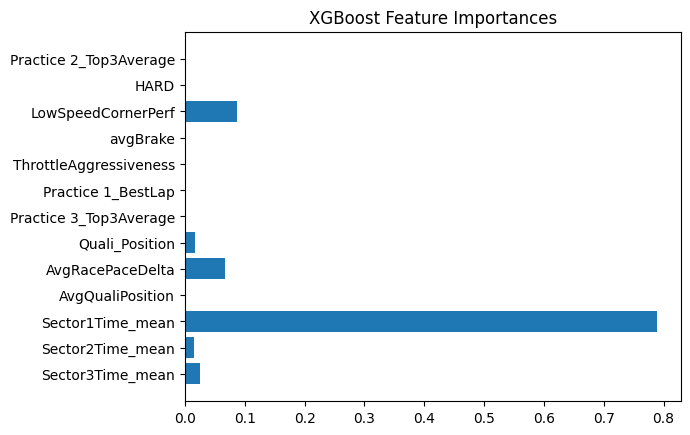

In [ ]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
plt.barh(X.columns, importances)
plt.title("XGBoost Feature Importances")
plt.show()

In [138]:
print("Feature importances:")
for feature, importance in zip(X.columns, importances): 
    print(f"{feature}: {importance:.4f}")

Feature importances:
Sector3Time_mean: 0.0249
Sector2Time_mean: 0.0153
Sector1Time_mean: 0.7896
AvgQualiPosition: 0.0000
AvgRacePaceDelta: 0.0666
Quali_Position: 0.0160
Practice 3_Top3Average: 0.0000
Practice 1_BestLap: 0.0000
ThrottleAggressiveness: 0.0000
avgBrake: 0.0000
LowSpeedCornerPerf: 0.0876
Practice 2_Top3Average: 0.0000


In [161]:

params = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 0.5, 1],
    "reg_lambda": [0.5, 1, 1.5]
}
model = XGBRegressor(random_state=42)
rand_search = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

rand_search.fit(X_train, y_train)
best_model = rand_search.best_estimator_
print("Best MAE:", -rand_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best MAE: 1.5163365721702575


In [ ]:
!pip uninstall numpy -y
!pip install numpy==2.2.0
!pip install shap

  Using cached numpy-2.2.0-cp313-cp313-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.0-cp313-cp313-win_amd64.whl (12.6 MB)


In [140]:
import numpy as np
print(np.__version__)

2.2.0


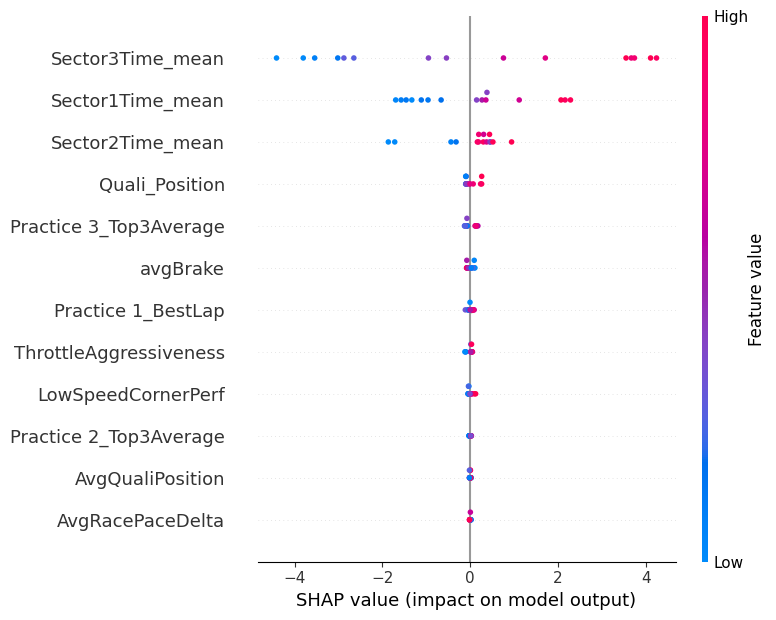

In [141]:
import shap
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)


In [142]:
import shap
shap.initjs()

i = 0  # choose a row index
shap.plots.force(shap_values[i])


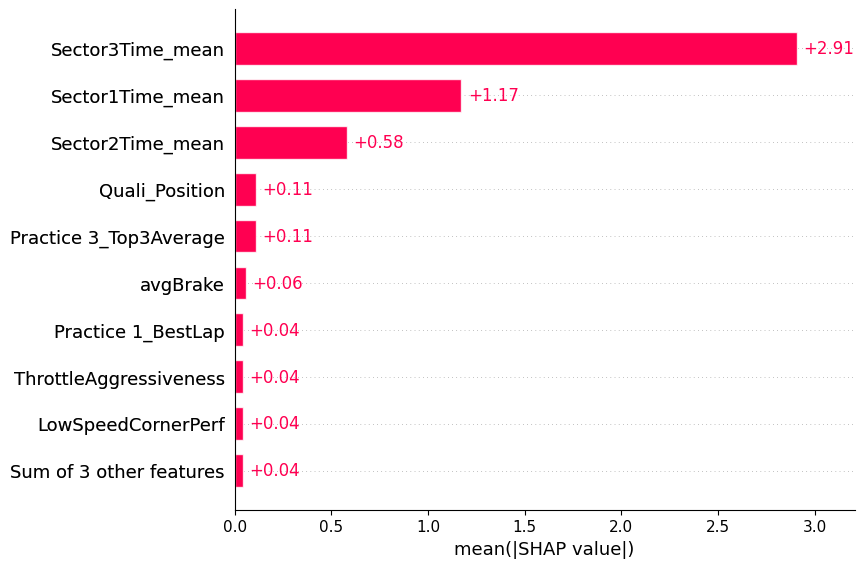

In [143]:
shap.plots.bar(shap_values)

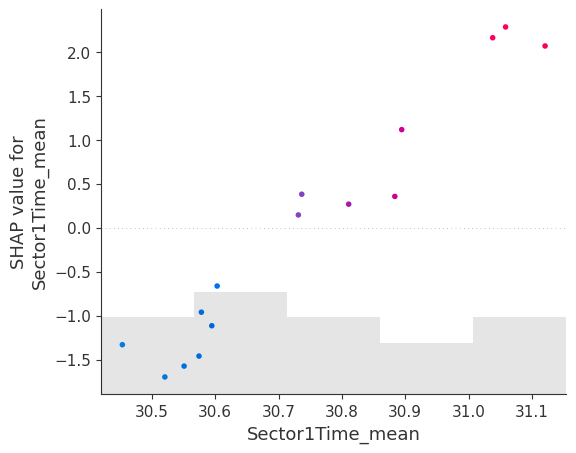

In [144]:
shap.plots.scatter(shap_values[:, "Sector1Time_mean"], color=shap_values)


In [145]:
for col in X.columns:
    print(col)

Sector3Time_mean
Sector2Time_mean
Sector1Time_mean
AvgQualiPosition
AvgRacePaceDelta
Quali_Position
Practice 3_Top3Average
Practice 1_BestLap
ThrottleAggressiveness
avgBrake
LowSpeedCornerPerf
Practice 2_Top3Average


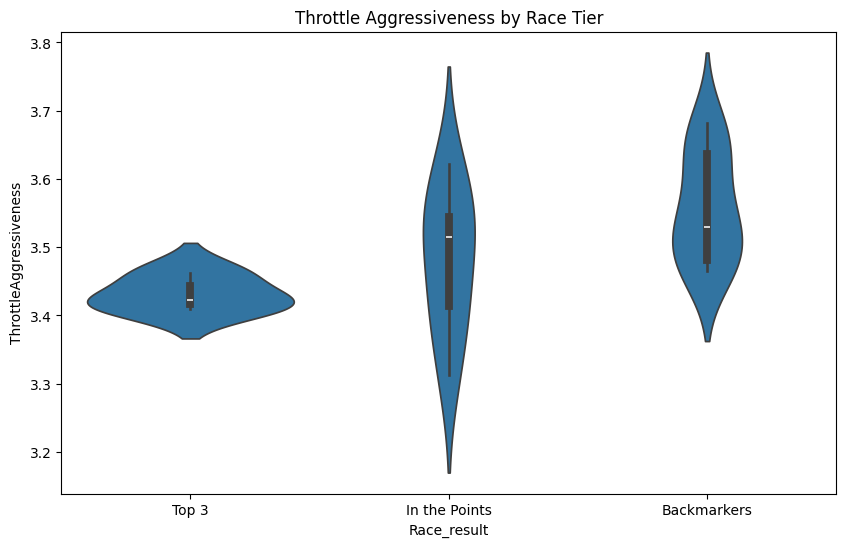

In [146]:
def label_position(pos):
    if pos <= 3:
        return 'Top 3'
    elif pos <= 10:
        return 'In the Points'
    else:
        return 'Backmarkers'

y_cat = y.apply(label_position)

plt.figure(figsize=(10, 6))
sns.violinplot(x=y_cat, y=X['ThrottleAggressiveness'])
plt.title("Throttle Aggressiveness by Race Tier")
plt.show()



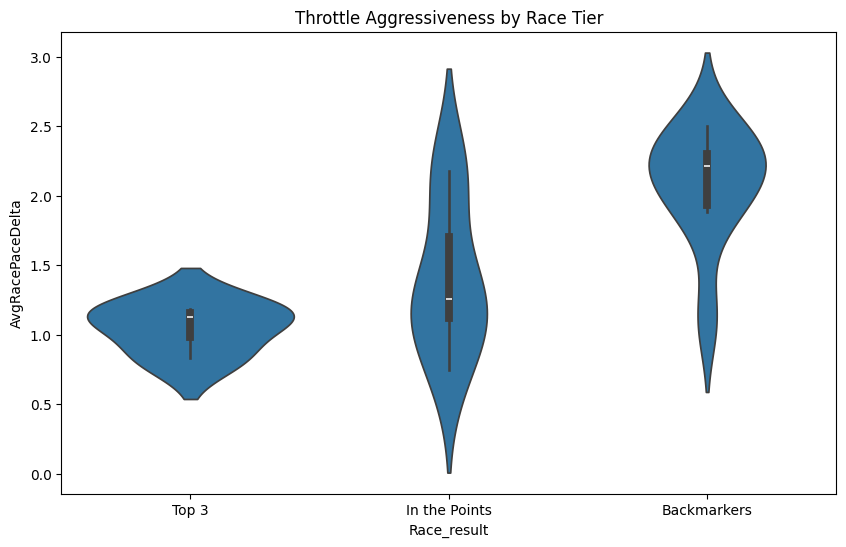

In [147]:
def label_position(pos):
    if pos <= 3:
        return 'Top 3'
    elif pos <= 10:
        return 'In the Points'
    else:
        return 'Backmarkers'

y_cat = y.apply(label_position)

plt.figure(figsize=(10, 6))
sns.violinplot(x=y_cat, y=X['AvgRacePaceDelta'])
plt.title("Throttle Aggressiveness by Race Tier")
plt.show()



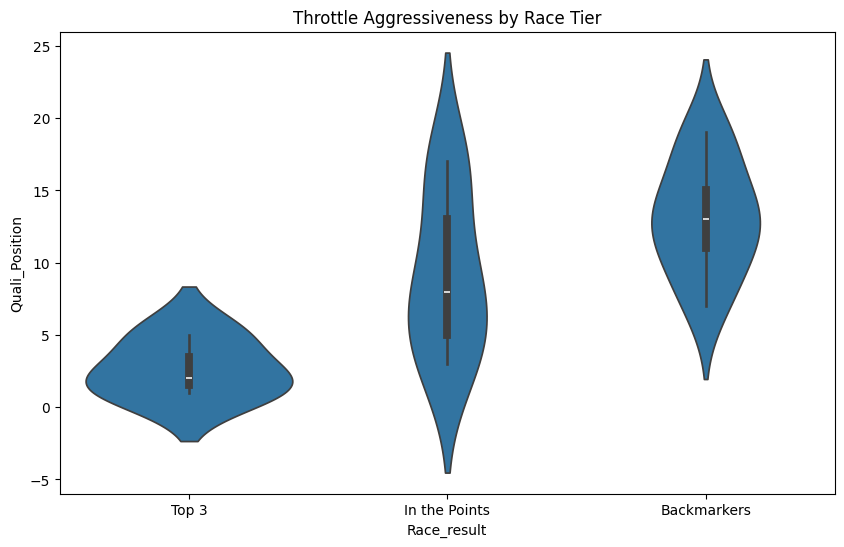

In [148]:
def label_position(pos):
    if pos <= 3:
        return 'Top 3'
    elif pos <= 10:
        return 'In the Points'
    else:
        return 'Backmarkers'

y_cat = y.apply(label_position)

plt.figure(figsize=(10, 6))
sns.violinplot(x=y_cat, y=X['Quali_Position'])
plt.title("Throttle Aggressiveness by Race Tier")
plt.show()

In [149]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor


In [150]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}


In [ ]:
model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # lower MAE = better
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 300], 'subsample': [0.8, 1.0]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [152]:
best_model = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)

from sklearn.metrics import mean_absolute_error
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Improved MAE:", mae)


Best Params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Improved MAE: 1.5279009342193604


In [153]:
import joblib

joblib.dump(best_model, "xgb_podium_predictor.pkl")
print("Model saved as xgb_podium_predictor.pkl")

Model saved as xgb_podium_predictor.pkl
